In [1]:
import pandas as pd
import cv2
import tifffile as tiff
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [2]:
df = pd.read_csv("dataset/train.csv")

In [3]:
df

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
5,b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
6,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
7,e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
8,095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...
9,54f2eec69,124967057 36 124997425 109 125027828 147 12505...


In [4]:
df_test = pd.read_csv("dataset/sample_submission.csv")

In [5]:
df_test

,id,predicted
0,2ec3f1bb9,NaN
1,3589adb90,NaN
2,d488c759a,NaN
3,aa05346ff,NaN
4,57512b7f1,NaN


In [6]:
def rle_decode(mask_rle, shape=(256, 256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_grid(shape, window=256, min_overlap=32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)

    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx*ny,4)

def resize_rectangles(rectangles, scale_x, scale_y):
    resized_rectangles = []
    for x, y, w, h in rectangles:
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)
        new_w = int(w * scale_x)
        new_h = int(h * scale_y)
        resized_rectangles.append((new_x, new_y, new_w, new_h))
    return resized_rectangles

def crop_image_and_mask(image, mask, margin = 500):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    rmin = max(0, rmin - margin)
    rmax = min(image.shape[0], rmax + margin)
    cmin = max(0, cmin - margin)
    cmax = min(image.shape[1], cmax + margin)

    cropped_image = image[rmin:rmax, cmin:cmax]
    cropped_mask = mask[rmin:rmax, cmin:cmax]

    return cropped_image, cropped_mask

In [7]:
def cut_image(image, scale=None, verbose=1, df = df):
    if image.shape[0] == 3:
        print("image shape = 3")
        image = np.transpose(image, (1, 2, 0))
    if len(image.shape) == 5:
        print("image shape = 5")
        image = image.squeeze().transpose(1, 2, 0)

    mask = rle_decode(df[df["id"] == image_id]["encoding"].values[0], (image.shape[0], image.shape[1]))

    cropped_image, cropped_mask = crop_image_and_mask(image, mask, margin = 500)

    contours, _ = cv2.findContours(cropped_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangles = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rectangles.append((x, y, w, h))
    
    if scale:
        new_size = (cropped_image.shape[1] // scale, cropped_image.shape[0] // scale)
        scale_x = new_size[0] / cropped_image.shape[1]
        scale_y = new_size[1] / cropped_image.shape[0]
        image = cv2.resize(cropped_image, new_size)
        mask = cv2.resize(cropped_mask, new_size)
        resized_rectangles = resize_rectangles(rectangles, scale_x, scale_y)

    return image, resized_rectangles

def show_image(image, resized_rectangles):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for rect in resized_rectangles:
        x, y, w, h = rect
        rect_patch = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect_patch)

    plt.show()

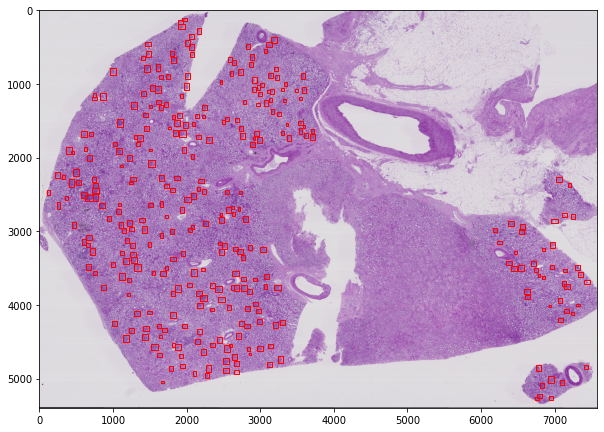

In [22]:
image_id = "cb2d976f4"
path = 'dataset/train/'
image = tiff.imread(os.path.join(path, f"{image_id}.tiff"))
image, resized_rectangles = cut_image(image, scale = 5)
show_image(image, resized_rectangles)

image shape = 3


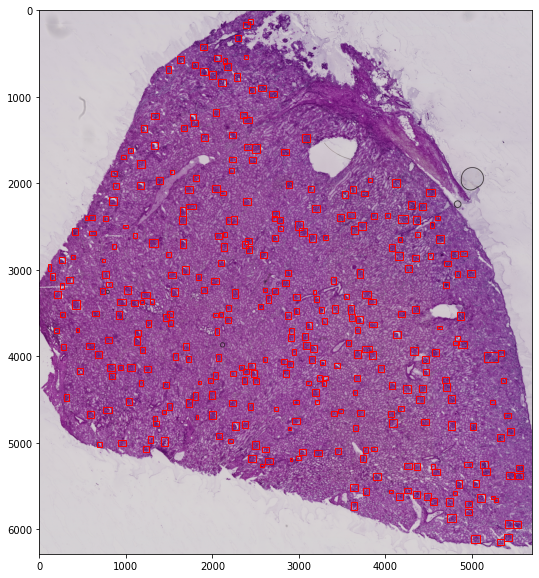

In [23]:
image_id = "095bf7a1f"
path = 'dataset/train/'
image = tiff.imread(os.path.join(path, f"{image_id}.tiff"))
image, resized_rectangles = cut_image(image, scale = 5)
show_image(image, resized_rectangles)

In [4]:
validation_set = ['095bf7a1f', '26dc41664']
training_set = ['cb2d976f4',
 '2f6ecfcdf',
 '8242609fa',
 'aaa6a05cc',
 'b9a3865fc',
 'b2dc8411c',
 '0486052bb',
 'e79de561c',
 '54f2eec69',
 '4ef6695ce',
 'c68fe75ea',
 'afa5e8098',
 '1e2425f28']

In [5]:
def label_convert_to_yolo_format(label, image_width, image_height):
    yolo_labels = []
    for bbox in label:
        x, y, w, h = bbox
        x_center = (x + w / 2) / image_width
        y_center = (y + h / 2) / image_height
        width = w / image_width
        height = h / image_height
        class_id = 0
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return yolo_labels

def image_convert_to_yolo_format(image):
    normalized_image = image / 255.0
    return normalized_image

In [26]:
!ls

FasterRCNN_1.ipynb  nohup.out		      test.png
TF-ESPCN	    resize.ipynb	      yolo_config.ipynb
YOLO_1.ipynb	    resize_10_dataset	      yolo_data_resize
data.yaml	    resize_5_dataset	      yolo_epoch50
dataset		    resolution.ipynb.invalid  yolo_test1.ipynb
faster_rcnn	    runs		      yolov8m.pt
new_data	    test.ipynb		      yolov8n.pt


In [27]:
# %mkdir dataset_resize_5
# %mkdir dataset_resize_5/images
# %mkdir dataset_resize_5/images/val
# %mkdir dataset_resize_5/images/train
# %mkdir dataset_resize_5/labels
# %mkdir dataset_resize_5/labels/val
# %mkdir dataset_resize_5/labels/train

In [33]:
#val set
path = 'dataset/train/'
for image_id in validation_set:
    image = tiff.imread(os.path.join(path, f"{image_id}.tiff"))
    image, label = cut_image(image, scale=5, verbose=1, df = df)
    print(image.shape)

    image_height = image.shape[0]
    image_width = image.shape[1]

    path_image = 'dataset_resize_5/images/val/' + image_id +'.png'
    print(path_image)

    image_uint8 = Image.fromarray(image)
    image_uint8.save(path_image)
    path_label = 'dataset_resize_5/labels/val/' + image_id +'.txt'

    yolo_labels = label_convert_to_yolo_format(label, image_width, image_height)

    with open(path_label, 'w') as file:
        for row in yolo_labels:
            file.write(row + '\n')

image shape = 3
(6284, 5695, 3)
dataset_resize_5/images/val/095bf7a1f.png
image shape = 3
(5613, 6583, 3)
dataset_resize_5/images/val/26dc41664.png


In [12]:
#training set
path = 'dataset/train/'
for image_id in training_set:
    image = tiff.imread(os.path.join(path, f"{image_id}.tiff"))
    image, label = cut_image(image, scale=5, verbose=1, df = df)
    print(image.shape)

    image_height = image.shape[0]
    image_width = image.shape[1]

    path_image = 'dataset_resize_5/images/train/' + image_id +'.png'
    print(path_image)

    image_uint8 = Image.fromarray(image)
    image_uint8.save(path_image)
    path_label = 'dataset_resize_5/labels/train/' + image_id +'.txt'

    yolo_labels = label_convert_to_yolo_format(label, image_width, image_height)

    with open(path_label, 'w') as file:
        for row in yolo_labels:
            file.write(row + '\n')

(5397, 7579, 3)
dataset_resize_5/images/train/cb2d976f4.png
(5191, 2765, 3)
dataset_resize_5/images/train/2f6ecfcdf.png
(5499, 7818, 3)
dataset_resize_5/images/train/8242609fa.png
(2972, 2075, 3)
dataset_resize_5/images/train/aaa6a05cc.png
(4562, 7619, 3)
dataset_resize_5/images/train/b9a3865fc.png
(1921, 5125, 3)
dataset_resize_5/images/train/b2dc8411c.png
(4328, 5589, 3)
dataset_resize_5/images/train/0486052bb.png
image shape = 5
(2866, 4941, 3)
dataset_resize_5/images/train/e79de561c.png
image shape = 5
(3966, 3448, 3)
dataset_resize_5/images/train/54f2eec69.png
image shape = 3
(7157, 9550, 3)
dataset_resize_5/images/train/4ef6695ce.png
image shape = 3
(4977, 9419, 3)
dataset_resize_5/images/train/c68fe75ea.png
(6243, 7987, 3)
dataset_resize_5/images/train/afa5e8098.png
image shape = 3
(3097, 6105, 3)
dataset_resize_5/images/train/1e2425f28.png


In [8]:
test_set = ['2ec3f1bb9','3589adb90','d488c759a','aa05346ff','57512b7f1']

In [11]:
def cut_image_test(image, scale=None, verbose=1):
    if image.shape[0] == 3:
        print("image shape = 3")
        image = np.transpose(image, (1, 2, 0))
    if len(image.shape) == 5:
        print("image shape = 5")
        image = image.squeeze().transpose(1, 2, 0)
    
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        scale_x = new_size[0] / image.shape[1]
        scale_y = new_size[1] / image.shape[0]
        resize_image = cv2.resize(image, new_size)

    return resize_image

In [14]:
#test set
path = 'dataset/test/'
for image_id in test_set:
    image = tiff.imread(os.path.join(path, f"{image_id}.tiff"))
    image = cut_image_test(image, scale = 5, verbose=1)
    print(image.shape)

    image_height = image.shape[0]
    image_width = image.shape[1]

    path_image = 'dataset_resize_5/images/test/' + image_id +'.png'
    print(path_image)

    image_uint8 = Image.fromarray(image)
    image_uint8.save(path_image)

(4798, 9544, 3)
dataset_resize_5/images/test/2ec3f1bb9.png
(5886, 4433, 3)
dataset_resize_5/images/test/3589adb90.png
image shape = 3
(9332, 5804, 3)
dataset_resize_5/images/test/d488c759a.png
image shape = 3
(6144, 9468, 3)
dataset_resize_5/images/test/aa05346ff.png
image shape = 3
(6648, 8632, 3)
dataset_resize_5/images/test/57512b7f1.png
